# Baseline, PCA, LDA and SVM analysis

- Task:

  - Come up with and implement a baseline for this task
  - Compare the performance of the simple baseline, PCA, LDA, and SVM using the Olivetti faces dataset in different evaluation scenarions

- Evaluation scenarios:

  - Use 20% of the images for training and 80% for testing
  - Use 50% of the images for training and 50% for testing
  - Use 80% of the images for training and 20% for testing
  - Always use the first K images per person for training, and the remaining ones for testing
  - Plot CMC curve and confusion matrix for each combination of scenario and method
  - If hyperparameters need to be selected, pull out a reasonable held-out set from the training set.

## Olivetti faces dataset (AT&T Laboratories Cambridge)

As described on the original website:

"_There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement)._"

The original dataset consisted of 92 x 112, while the version available here consists of 64x64 images.

- Classes: 40
- Samples per class: 10
- Samples total: 400
- Dimensionality: 4096 (64x64 pixels)
- Pixel values: real, between 0 and 1


In [1]:
from sklearn.datasets import fetch_olivetti_faces
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the dataset


In [2]:
faces = fetch_olivetti_faces()

_, img_height, img_width = faces.images.shape

print(faces.images.shape)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
(400, 64, 64)


# Split the dataset


In [3]:
from sklearn.model_selection import train_test_split

N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
# use the first GALLERY_SIZE images per individual for training, the rest for testing
# scenario 1: 20% of the images for training and 80% for testing
# scenario 2: 50% of the images for training and 50% for testing
# scenario 3: 80% of the images for training and 20% for testing
GALLERY_SIZE = [2, 5, 8]

def split(N_IDENTITIES, GALLERY_SIZE, validation_size = 0.25):
  gallery_indices = []
  probe_indices = []

  for i in range(N_IDENTITIES):
    indices = list(np.where(faces.target == i)[0])
    gallery_indices += indices[:GALLERY_SIZE]
    probe_indices += indices[GALLERY_SIZE:]

  x_train = faces.images[gallery_indices].reshape(-1, img_height*img_width) # vectorize train images
  y_train = faces.target[gallery_indices]
  x_test = faces.images[probe_indices].reshape(-1, img_height*img_width)    # vectorize test images
  y_test = faces.target[probe_indices]

  x_val = x_train[:int(validation_size*len(x_train))]
  y_val = y_train[:int(validation_size*len(y_train))]

  return x_train, y_train, x_test, y_test, x_val, y_val
x_train_1, y_train_1, x_test_1, y_test_1, x_val_1, y_val_1 = split(N_IDENTITIES, 2)
x_train_2, y_train_2, x_test_2, y_test_2, x_val_2, y_val_2 = split(N_IDENTITIES, 5)
x_train_3, y_train_3, x_test_3, y_test_3, x_val_3, y_val_3 = split(N_IDENTITIES, 8)

print(x_train_1.shape, y_train_1.shape, x_test_1.shape, y_test_1.shape, x_val_1.shape, y_val_1.shape)
print(x_train_2.shape, y_train_2.shape, x_test_2.shape, y_test_2.shape)
print(x_train_3.shape, y_train_3.shape, x_test_3.shape, y_test_3.shape)

(80, 4096) (80,) (320, 4096) (320,) (20, 4096) (20,)
(200, 4096) (200,) (200, 4096) (200,)
(320, 4096) (320,) (80, 4096) (80,)


In [4]:
len(np.unique(y_train_1)), len(np.unique(y_test_1))

(40, 40)

# Visualize the splits


In [5]:
def show_images(imgs, num_rows, num_cols):
  assert len(imgs) == num_rows*num_cols

  for i in range(num_rows):
    row = None
    for j in range(num_cols):
      if row is None:
        row = imgs[i*num_cols+j].reshape(img_height, img_width)*255.0
      else:
        row = np.concatenate((row, imgs[i*num_cols+j].reshape(img_height, img_width)*255.0), axis=1)
    cv2_imshow(row)

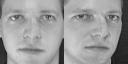

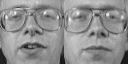

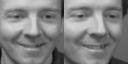

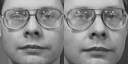

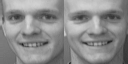

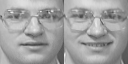

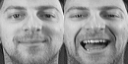

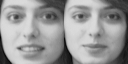

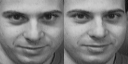

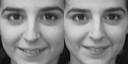

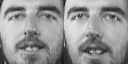

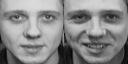

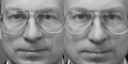

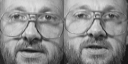

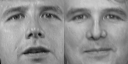

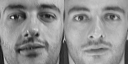

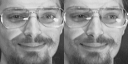

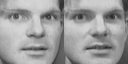

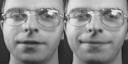

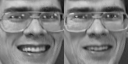

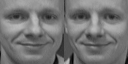

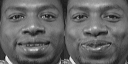

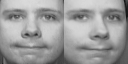

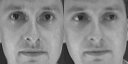

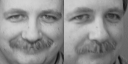

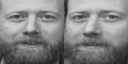

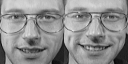

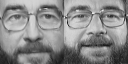

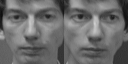

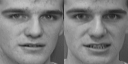

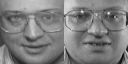

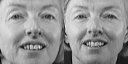

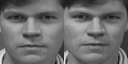

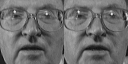

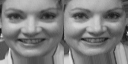

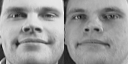

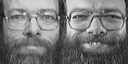

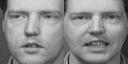

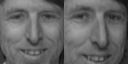

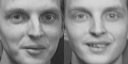

In [6]:
show_images(x_train_1, N_IDENTITIES,  GALLERY_SIZE[0])

In [7]:
y_train_1.shape,N_IDENTITIES

((80,), 40)

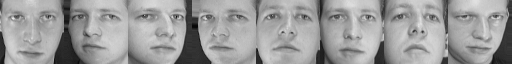

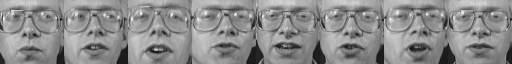

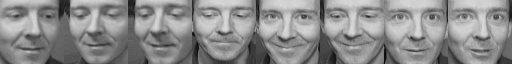

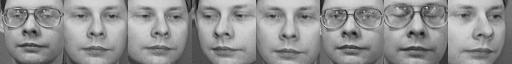

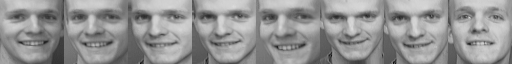

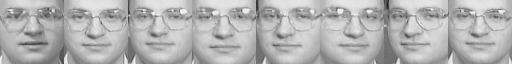

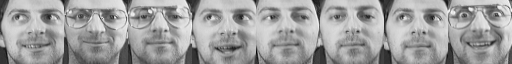

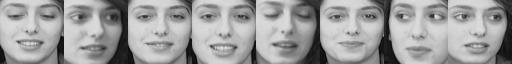

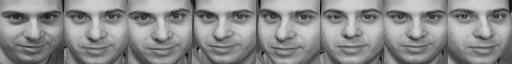

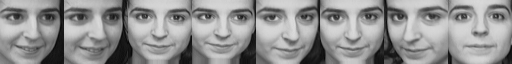

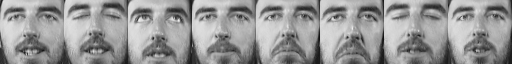

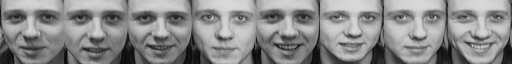

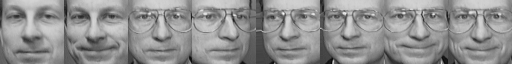

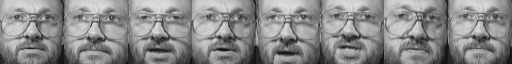

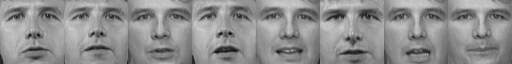

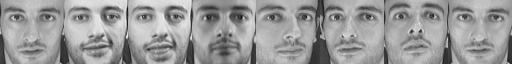

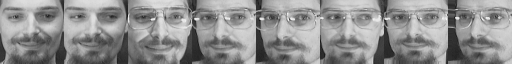

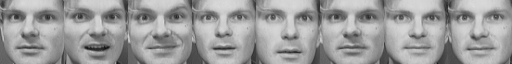

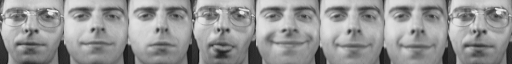

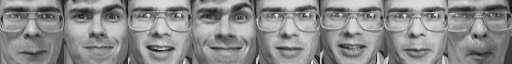

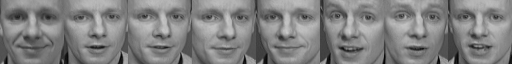

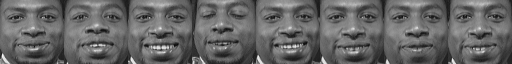

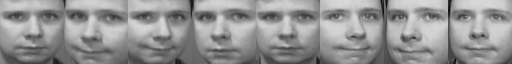

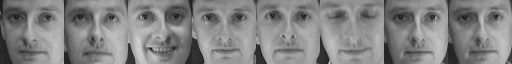

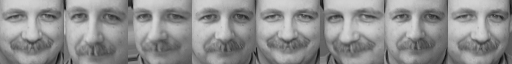

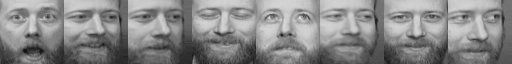

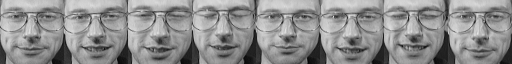

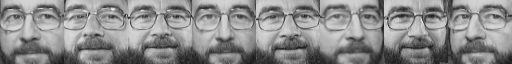

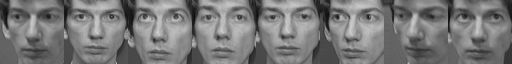

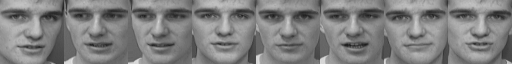

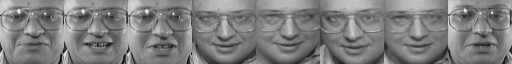

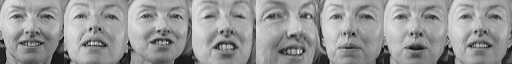

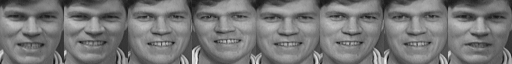

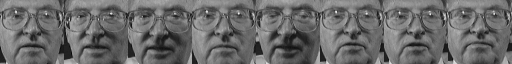

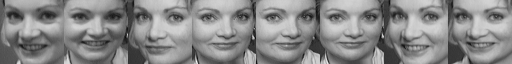

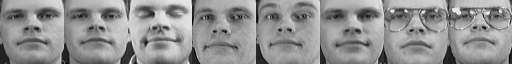

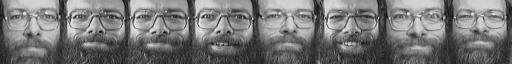

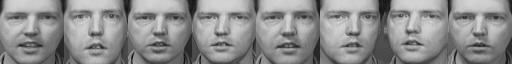

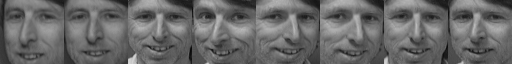

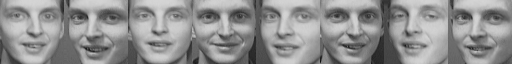

In [8]:
show_images(x_test_1, N_IDENTITIES,  10 - GALLERY_SIZE[0])

# Implement my baseline - K - Nearest Neighbors


For this task, I choose K - Nearest Neighbors instead of Naive Bayes (what we learn on class) because for face recognition, where the task involves working with high-dimensional image data and the feature independence assumption is likely to be violated, k-NN can be more appropriate due to its flexibility, non-parametric nature, and effectiveness in handling complex, high-dimensional data. Naive Bayes, while powerful in certain scenarios such as text classification, might not be as effective in this particular context due to its underlying assumptions.

k-NN is a non-parametric, instance-based learning algorithm. It doesn't make any assumptions about the underlying data distribution, which can be advantageous in complex problems like face recognition where the data distribution might be unknown or highly varied. k-NN works by comparing the distances between instances. In face recognition, where the task is often about finding the most similar faces, k-NN's approach of comparing image features directly can be very effective.

On the other hand, Naive Bayes assumes that the features are independent of each other given the class label. However, in face recognition, this assumption is often violated as pixel values in images are usually highly correlated.

I also use the validation dataset to choose the best n-neighbors.


Scenario 1: 20% of the images for training and 80% for testing
Best number of neighbors: 1
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       1.00      1.00      1.00         8
           2       0.25      0.12      0.17         8
           3       1.00      0.38      0.55         8
           4       0.39      0.88      0.54         8
           5       1.00      0.75      0.86         8
           6       0.83      0.62      0.71         8
           7       1.00      0.25      0.40         8
           8       0.57      0.50      0.53         8
           9       1.00      0.50      0.67         8
          10       0.67      1.00      0.80         8
          11       1.00      0.88      0.93         8
          12       1.00      0.25      0.40         8
          13       1.00      1.00      1.00         8
          14       0.44      1.00      0.62         8
          15       1.00      0.88      0.93 

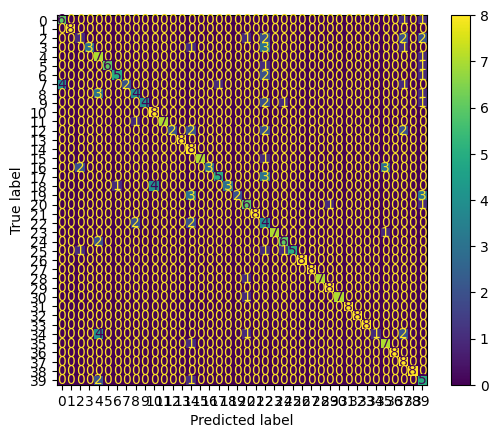

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np

def knn_build_and_result(x_train, y_train, x_val, y_val, x_test, y_test, scenario):
    print(scenario)

    best_n_neighbors = 1
    best_accuracy = 0

    for n_neighbors in range(1, 10):
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(x_train, y_train)
        y_val_pred = knn.predict(x_val)
        accuracy = np.mean(y_val_pred == y_val)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_neighbors = n_neighbors

    print(f"Best number of neighbors: {best_n_neighbors}")


    knn_final = KNeighborsClassifier(n_neighbors=best_n_neighbors)
    knn_final.fit(np.vstack((x_train, x_val)), np.hstack((y_train, y_val)))

    y_pred = knn_final.predict(x_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(classification_rep)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()

knn_build_and_result(x_train_1, y_train_1, x_val_1, y_val_1, x_test_1, y_test_1, 'Scenario 1: 20% of the images for training and 80% for testing')

Scenerio 2: 50% of the images for training and 50% for testing
Best number of neighbors: 1
              precision    recall  f1-score   support

           0       0.45      1.00      0.62         5
           1       1.00      1.00      1.00         5
           2       1.00      0.20      0.33         5
           3       1.00      0.80      0.89         5
           4       0.50      0.80      0.62         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.75      0.60      0.67         5
           8       1.00      0.80      0.89         5
           9       1.00      0.40      0.57         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.80      0.80      0.80         5
          13       1.00      1.00      1.00         5
          14       0.83      1.00      0.91         5
          15       1.00      1.00      1.00 

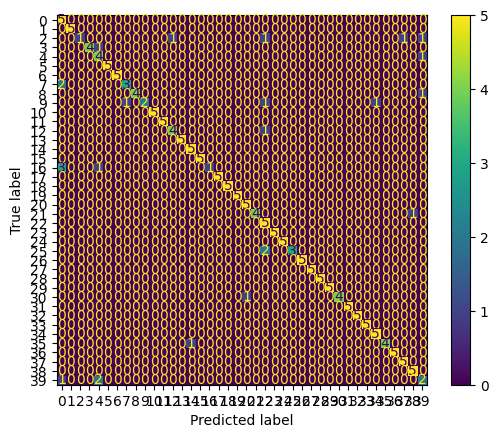

In [10]:
knn_build_and_result(x_train_2, y_train_2, x_val_2, y_val_2, x_test_2, y_test_2, 'Scenerio 2: 50% of the images for training and 50% for testing')

Scenerio 3: 80% of the images for training and 20% for testing
Best number of neighbors: 1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      1.00      1.00         2
           2       0.00      0.00      0.00         2
           3       1.00      0.50      0.67         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.50      0.50      0.50         2
           8       1.00      0.50      0.67         2
           9       0.00      0.00      0.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       0.50      1.00      0.67         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      0.50      0.67         2
          16       1.00      1.00      1.00         2
          17       1.00    

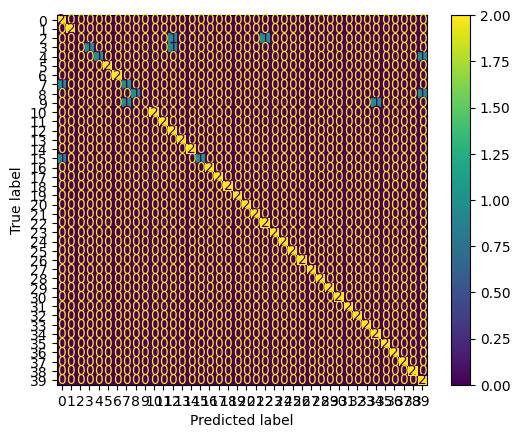

In [11]:
knn_build_and_result(x_train_3, y_train_3, x_val_3, y_val_3, x_test_3, y_test_3, 'Scenerio 3: 80% of the images for training and 20% for testing')

To plot CMC Curve, I have to calculate the distances between test and training images, then rank the training images for each test image based on these distances. The CMC curve will be plotted based on the ranks.


In [12]:
from sklearn.metrics import pairwise_distances

def cmc_curve_knn(x_test, x_train, y_test, y_train, scenerio):
  distances = pairwise_distances(x_test, x_train, metric='euclidean')

  ranks = np.argsort(distances, axis=1)

  ranks_df = pd.DataFrame(ranks)

  cmc_scores = []
  for i in range(len(y_test)):
      correct_class = y_test[i]
      match_ranks = np.where(y_train[ranks[i]] == correct_class)[0]
      first_correct_match = match_ranks[0] if len(match_ranks) > 0 else None
      cmc_scores.append(first_correct_match)

  # Calculate the cumulative match characteristic (CMC) curve
  cmc_curve = pd.Series(cmc_scores).value_counts().sort_index().cumsum()
  cmc_curve /= cmc_curve.iloc[-1]

  plt.figure(figsize=(10, 6))
  plt.plot(cmc_curve, marker='o')
  plt.title(f'CMC Curve for k-NN Model Scenerio {scenerio}')
  plt.xlabel('Rank')
  plt.ylabel('Identification Rate')
  plt.grid(True)
  plt.show()

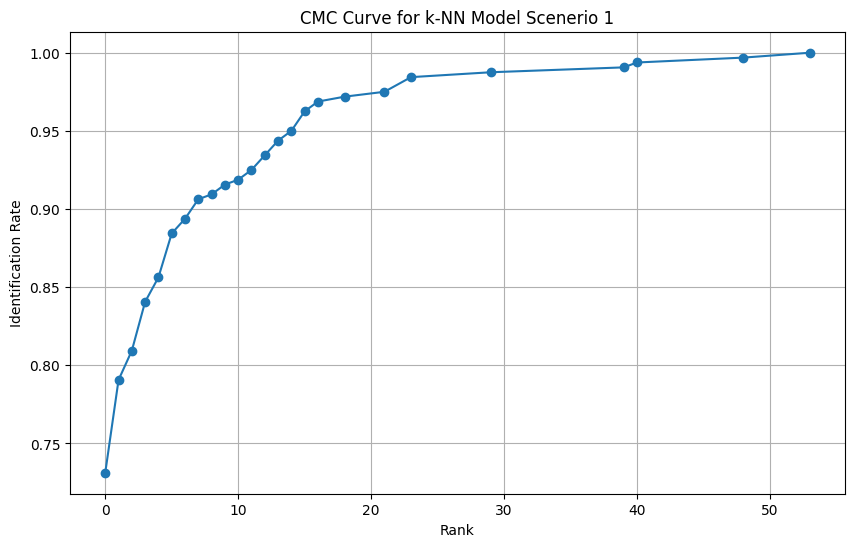

In [13]:
cmc_curve_knn(x_test_1, x_train_1, y_test_1, y_train_1, 1)

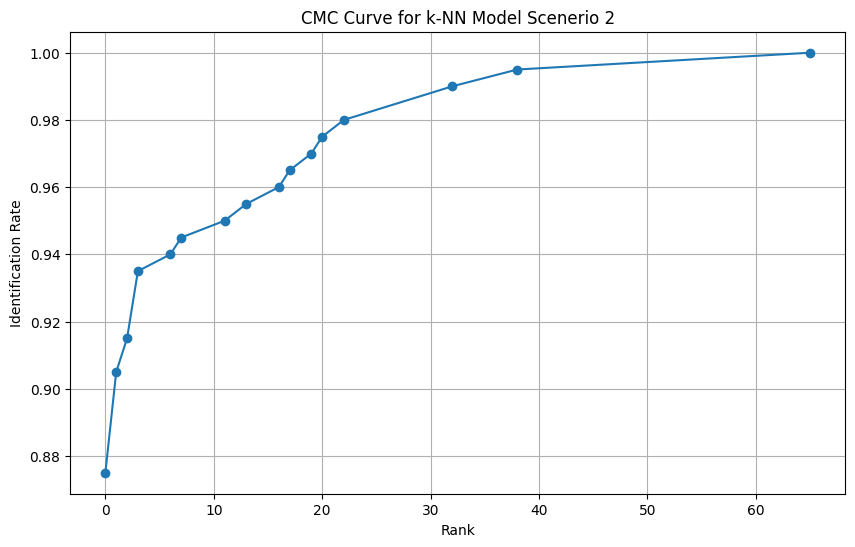

In [14]:
cmc_curve_knn(x_test_2, x_train_2, y_test_2, y_train_2, 2)

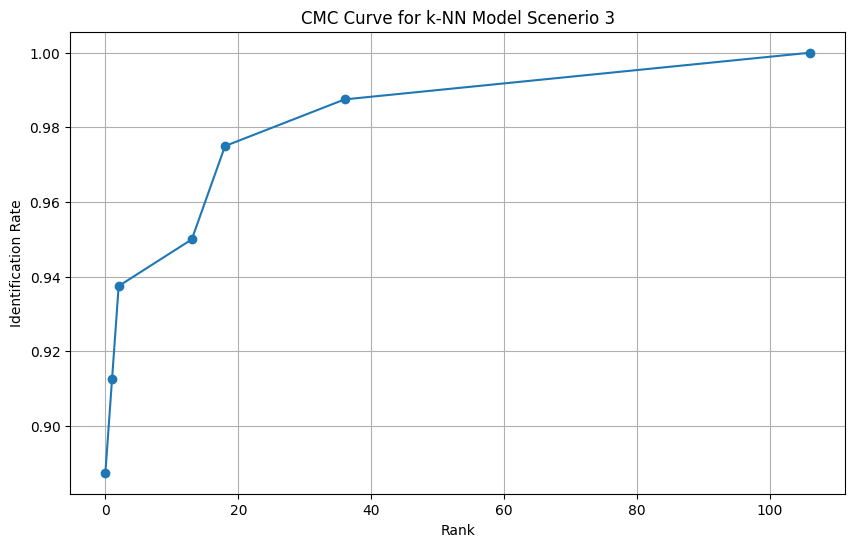

In [15]:
cmc_curve_knn(x_test_3, x_train_3, y_test_3, y_train_3, 3)

# Run the experiments on PCA, LDA, SVM

1. Principal Component Analysis (PCA)
2. Linear Discriminant Analysis (LDA)
3. Support Vector Machine (SVM)


## Principal Component Analysis (PCA)


4096
(80, 4096)
(80, 2)
[0.2438122  0.10267439]


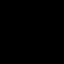

In [16]:
from sklearn.decomposition import PCA
img_height, img_width = 64, 64
pca = PCA(n_components=2)
projected = pca.fit_transform(x_train_1.reshape(-1, img_height*img_width))
print(img_height*img_width)
print(x_train_1.shape)
print(projected.shape)

print(pca.explained_variance_ratio_)

cv2_imshow(pca.mean_.reshape(img_height, img_height))

In [17]:
def run_pca(x_train, y_train, x_test, y_test, scenario):
    n_eigen = []
    rank1 = []
    predicted_labels = []
    for i in range(10, x_train.shape[0], 10):

        pca = PCA(n_components=i)
        pca.fit(x_train.reshape(-1, img_height*img_width))


        gallery = pca.transform(x_train.reshape(-1, img_height*img_width))
        probe = pca.transform(x_test.reshape(-1, img_height*img_width))

        acc = 0
        predictions = []
        for j in range(len(probe)):
            closest = 0
            closest_dist = np.sum((gallery[0] - probe[j])**2)
            for k in range(1, len(gallery)):
                dist = np.sum((gallery[k] - probe[j])**2)
                if dist < closest_dist:
                    closest_dist = dist
                    closest = k
            if y_test[j] == y_train[closest]:
                acc += 1
            predictions.append(y_train[closest])

        acc = accuracy_score(y_test, predictions)
        print(f"Accuracy for {i} eigenfaces: {acc:.2f}")

        n_eigen.append(i)
        rank1.append(acc * 100)
        predicted_labels.append(predictions)

    # Plot Rank-1 Accuracy vs Number of Eigenfaces
    plt.plot(n_eigen, rank1)
    plt.ylim(0, 100)
    plt.xlabel('Number of Eigenfaces')
    plt.ylabel('Rank-1 Accuracy (%)')
    plt.title(f'PCA Rank-1 Accuracy for Scenario {scenario}')
    plt.show()

    conf_matrix = confusion_matrix(y_test, predicted_labels[-1])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.title(f'Confusion Matrix for {n_eigen[-1]} Eigenfaces (Scenario {scenario})')
    plt.show()

In [18]:
def pca_draw_cmc(x_train, x_test, y_train, y_test, scenerio):
  for i in range(10,79,10):
    pca = PCA(n_components=i)
    pca.fit(x_train.reshape(-1, img_height*img_width))

    gallery = pca.transform(x_train.reshape(-1, img_height*img_width))
    probe = pca.transform(x_test.reshape(-1, img_height*img_width))

    CMC = {}
    for j in range(len(probe)):
      genuine_dist = np.inf
      for k in range(len(gallery)):
        if y_test[j] == y_train[k]:
          dist = np.sum((gallery[k]-probe[j])**2)
          if dist < genuine_dist:
            genuine_dist = dist
      ids = set()
      for k in range(len(gallery)):
        if y_test[j] != y_train[k]:
          dist = np.sum((gallery[k]-probe[j])**2)
          if dist < genuine_dist:
            ids.add(y_train[k])
      rank=1+len(ids)
      if rank not in CMC:
        CMC[rank] = 1
      else:
        CMC[rank] += 1

    rank = []
    acc = []
    total = 0
    for j in range(1, N_IDENTITIES+1):
      if j in CMC:
        total += CMC[j]
      rank.append(j)
      acc.append(100.0*total/len(probe))

    plt.plot(rank, acc, label=str(i)+' eigenvectors')
    plt.legend()
    plt.ylim(0, 100)
    plt.plot()

### Scenario 1


Accuracy for 10 eigenfaces: 0.57
Accuracy for 20 eigenfaces: 0.66
Accuracy for 30 eigenfaces: 0.69
Accuracy for 40 eigenfaces: 0.72
Accuracy for 50 eigenfaces: 0.72
Accuracy for 60 eigenfaces: 0.72
Accuracy for 70 eigenfaces: 0.72


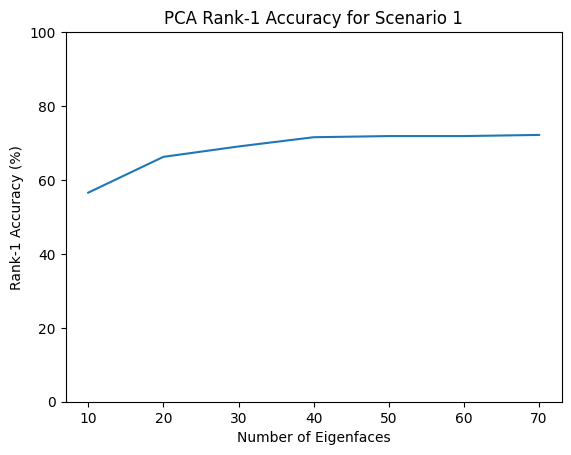

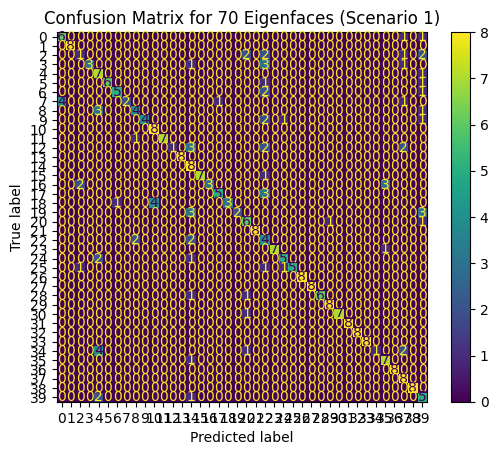

In [19]:
run_pca(x_train_1, y_train_1, x_test_1, y_test_1, 1)

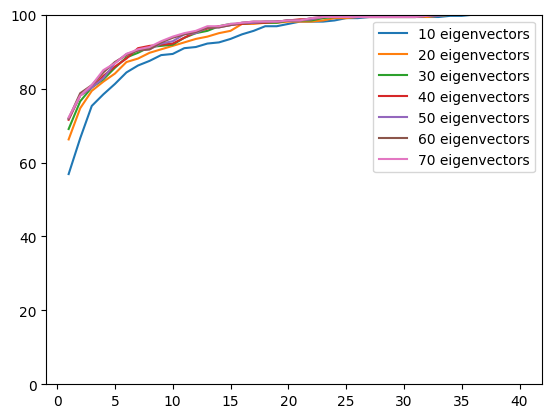

In [20]:
pca_draw_cmc(x_train_1, x_test_1, y_train_1, y_test_1, 1)

### Scenario 2


Accuracy for 10 eigenfaces: 0.76
Accuracy for 20 eigenfaces: 0.84
Accuracy for 30 eigenfaces: 0.84
Accuracy for 40 eigenfaces: 0.85
Accuracy for 50 eigenfaces: 0.86
Accuracy for 60 eigenfaces: 0.86
Accuracy for 70 eigenfaces: 0.88
Accuracy for 80 eigenfaces: 0.88
Accuracy for 90 eigenfaces: 0.88
Accuracy for 100 eigenfaces: 0.88
Accuracy for 110 eigenfaces: 0.87
Accuracy for 120 eigenfaces: 0.87
Accuracy for 130 eigenfaces: 0.88
Accuracy for 140 eigenfaces: 0.88
Accuracy for 150 eigenfaces: 0.88
Accuracy for 160 eigenfaces: 0.88
Accuracy for 170 eigenfaces: 0.88
Accuracy for 180 eigenfaces: 0.88
Accuracy for 190 eigenfaces: 0.88


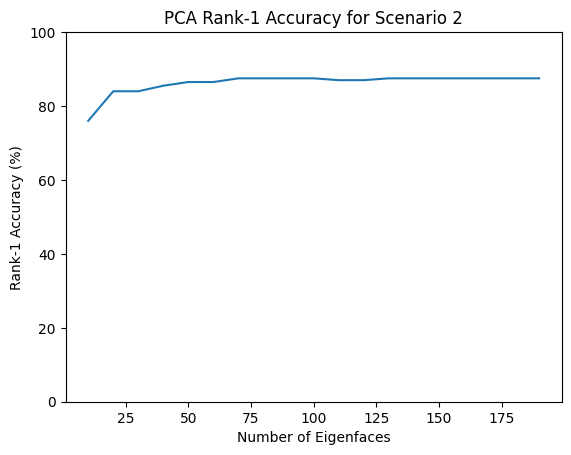

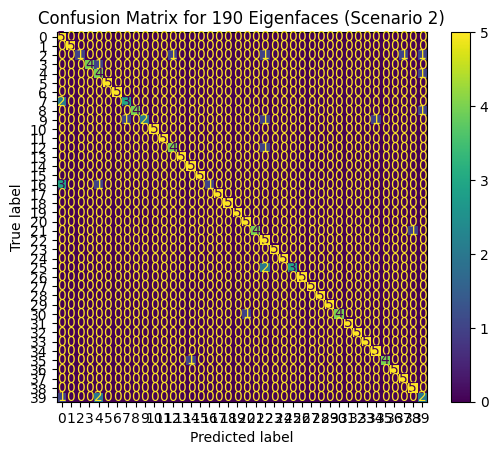

In [21]:
run_pca(x_train_2, y_train_2, x_test_2, y_test_2, 2)


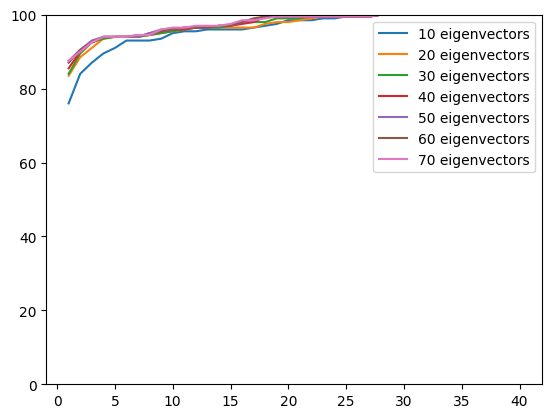

In [22]:
pca_draw_cmc(x_train_2, x_test_2, y_train_2, y_test_2, 2)

### Scenario 3


Accuracy for 10 eigenfaces: 0.81
Accuracy for 20 eigenfaces: 0.88
Accuracy for 30 eigenfaces: 0.86
Accuracy for 40 eigenfaces: 0.86
Accuracy for 50 eigenfaces: 0.89
Accuracy for 60 eigenfaces: 0.89
Accuracy for 70 eigenfaces: 0.89
Accuracy for 80 eigenfaces: 0.89
Accuracy for 90 eigenfaces: 0.89
Accuracy for 100 eigenfaces: 0.89
Accuracy for 110 eigenfaces: 0.89
Accuracy for 120 eigenfaces: 0.89
Accuracy for 130 eigenfaces: 0.89
Accuracy for 140 eigenfaces: 0.89
Accuracy for 150 eigenfaces: 0.89
Accuracy for 160 eigenfaces: 0.89
Accuracy for 170 eigenfaces: 0.89
Accuracy for 180 eigenfaces: 0.89
Accuracy for 190 eigenfaces: 0.89
Accuracy for 200 eigenfaces: 0.89
Accuracy for 210 eigenfaces: 0.89
Accuracy for 220 eigenfaces: 0.89
Accuracy for 230 eigenfaces: 0.89
Accuracy for 240 eigenfaces: 0.89
Accuracy for 250 eigenfaces: 0.89
Accuracy for 260 eigenfaces: 0.89
Accuracy for 270 eigenfaces: 0.89
Accuracy for 280 eigenfaces: 0.89
Accuracy for 290 eigenfaces: 0.89
Accuracy for 300 eigenf

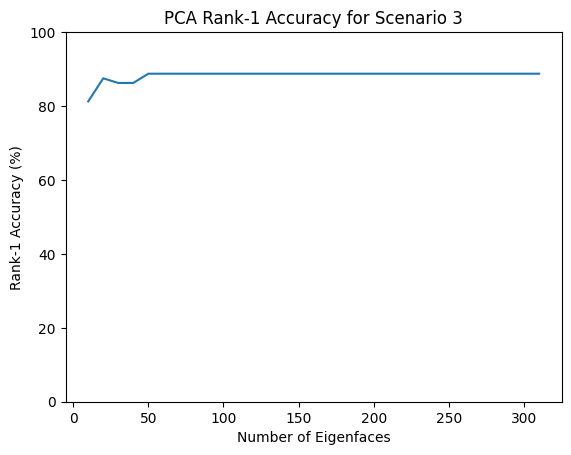

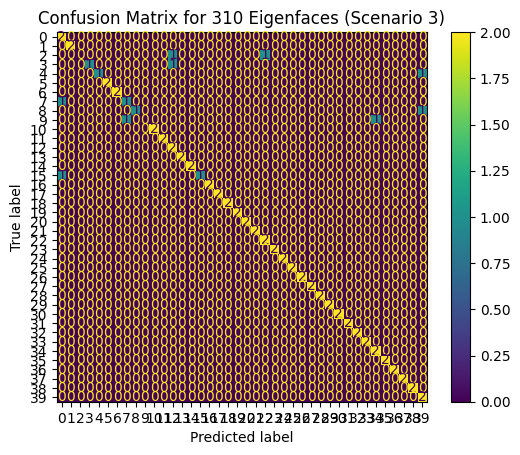

In [23]:
run_pca(x_train_3, y_train_3, x_test_3, y_test_3, 3)

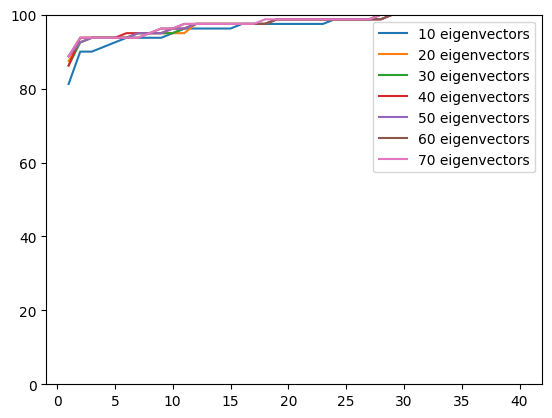

In [24]:
pca_draw_cmc(x_train_3, x_test_3, y_train_3, y_test_3, 3)

## Linear Discriminant Analysis (LDA)


In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
def run_lda(x_train, y_train, x_test, y_test):
  lda = LDA()
  lda.fit(x_train.reshape(-1, img_height * img_width), y_train)


  y_pred = lda.predict(x_test.reshape(-1, img_height * img_width))

  classification_rep = classification_report(y_test, y_pred)
  print('Classification Report: ', classification_rep)

  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy}")


  conf_matrix = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)


  disp.plot()
  plt.show()

In [26]:
def draw_lda(x_train, y_train, x_test, y_test, scenario):
  print(f'CMC curve for scenario {scenario}')
  for i in range(10,40,10):
    lda = LDA(n_components=i)
    lda.fit(x_train.reshape(-1, img_height*img_width), y_train)

    gallery = lda.transform(x_train.reshape(-1, img_height*img_width))
    probe = lda.transform(x_test.reshape(-1, img_height*img_width))

    CMC = {}
    # For each test case...
    for j in range(len(probe)):
      # Compute the distance to closest correct label.
      genuine_dist = np.inf
      for k in range(len(gallery)):
        if y_test[j] == y_train[k]:
          dist = np.sum((gallery[k]-probe[j])**2)
          if dist < genuine_dist:
            genuine_dist = dist
      # Compute number of incorrect labels closer than closest correct label.
      ids = set()
      for k in range(len(gallery)):
        if y_test[j] != y_train[k]:
          dist = np.sum((gallery[k]-probe[j])**2)
          if dist < genuine_dist:
            ids.add(y_train[k])
      # Record rank of closest correct label.
      rank=1+len(ids)
      if rank not in CMC:
        CMC[rank] = 1
      else:
        CMC[rank] += 1

    rank = []
    acc = []
    total = 0
    for j in range(1, N_IDENTITIES+1):
      if j in CMC:
        total += CMC[j]
      rank.append(j)
      acc.append(100.0*total/len(probe))

    plt.plot(rank, acc, label=str(i)+' eigenvectors')
    plt.legend()
    plt.ylim(0, 100)
    plt.plot()

### Scenario 1


Classification Report:                precision    recall  f1-score   support

           0       0.50      0.50      0.50         8
           1       0.89      1.00      0.94         8
           2       1.00      0.12      0.22         8
           3       0.57      0.50      0.53         8
           4       0.71      0.62      0.67         8
           5       0.73      1.00      0.84         8
           6       0.80      0.50      0.62         8
           7       1.00      0.25      0.40         8
           8       0.62      0.62      0.62         8
           9       1.00      0.50      0.67         8
          10       0.67      1.00      0.80         8
          11       1.00      0.62      0.77         8
          12       0.80      0.50      0.62         8
          13       1.00      1.00      1.00         8
          14       0.64      0.88      0.74         8
          15       1.00      0.75      0.86         8
          16       0.38      0.38      0.38         8
   

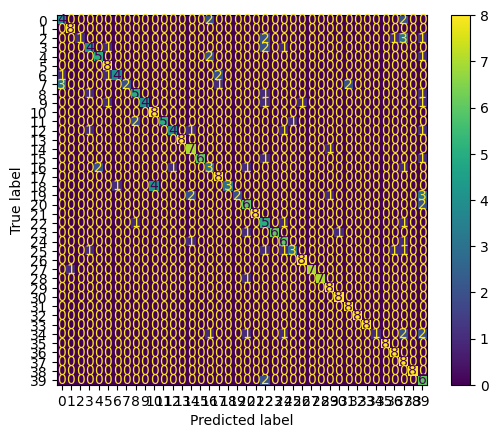

In [27]:
run_lda(x_train_1, y_train_1, x_test_1, y_test_1)

CMC curve for scenario 1


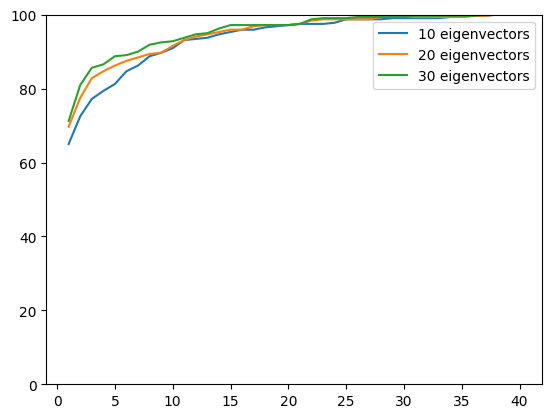

In [28]:
draw_lda(x_train_1, y_train_1, x_test_1, y_test_1, 1)

### Scenario 2


Classification Report:                precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         5
           2       1.00      0.40      0.57         5
           3       1.00      0.60      0.75         5
           4       1.00      0.80      0.89         5
           5       0.83      1.00      0.91         5
           6       1.00      0.80      0.89         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.67      0.80      0.73         5
          13       1.00      1.00      1.00         5
          14       0.83      1.00      0.91         5
          15       1.00      1.00      1.00         5
          16       1.00      0.20      0.33         5
   

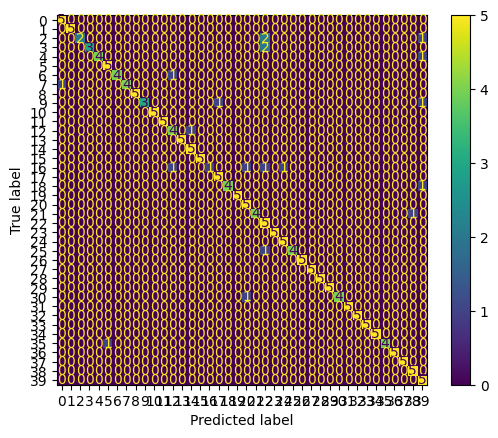

In [29]:
run_lda(x_train_2, y_train_2, x_test_2, y_test_2)

CMC curve for scenario 2


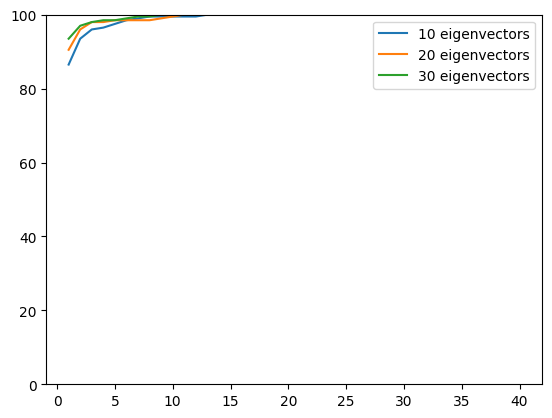

In [30]:
draw_lda(x_train_2, y_train_2, x_test_2, y_test_2, 2)

### Scenario 3


Classification Report:                precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
   

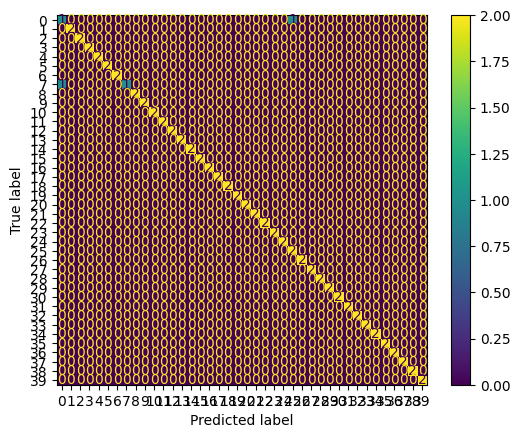

In [31]:
run_lda(x_train_3, y_train_3, x_test_3, y_test_3)

CMC curve for scenario 3


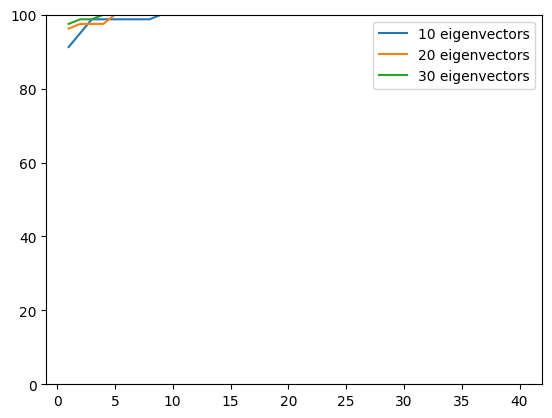

In [32]:
draw_lda(x_train_3, y_train_3, x_test_3, y_test_3, 3)

## Support Vector Machine (SVM)


In [33]:
from sklearn.svm import SVC

def run_svm(x_train, x_test, y_train, y_test, scenario):
  print(f'SVM model for scenario {scenario}')
  model = SVC(kernel='linear')
  model.fit(x_train, y_train)

  yfit = model.predict(x_test)
  print("\nClassification Report:\n", classification_report(y_test, yfit))
  conf_matrix = confusion_matrix(y_test, yfit)
  print("Confusion Matrix:\n", conf_matrix)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
  disp.plot()
  plt.show()


In [34]:
def plot_CMC(x_train, y_train, x_test, y_test):
  model = SVC(kernel='linear', probability=True)
  model.fit(x_train, y_train)

  yfit = model.predict_proba(x_test)
  ysimilarity = yfit

  ytarget = y_test
  assert len(ysimilarity) == len(ytarget)
  CMC = {}
  for i in range(len(ysimilarity)):
    # get similarity for the correct class
    genuine_sim = ysimilarity[i][ytarget[i]]
    # count how many incorrect classes have higher similarity
    rank = 1
    for j, sim in enumerate(ysimilarity[i]):
      if j != ytarget[i]:
        if sim >= genuine_sim:
          rank += 1
    # save rank
    if rank not in CMC:
      CMC[rank] = 1
    else:
      CMC[rank] += 1

  # cumulative sum to create CMC
  N = []
  rankN = []
  total = 0
  for i in range(1,len(ysimilarity[0])+1):
    if i in CMC:
      total += CMC[i]
    N.append(i)
    rankN.append(100.0*total/len(ysimilarity))

  plt.plot(N, rankN)
  plt.plot()

### Scenario 1


SVM model with hyperparameter tuning for scenario 1
Fitting 2 folds for each of 72 candidates, totalling 144 fits
Best parameters found:  {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       1.00      1.00      1.00         8
           2       0.20      0.12      0.15         8
           3       1.00      0.38      0.55         8
           4       0.50      0.88      0.64         8
           5       1.00      1.00      1.00         8
           6       0.83      0.62      0.71         8
           7       1.00      0.38      0.55         8
           8       0.71      0.62      0.67         8
           9       1.00      0.62      0.77         8
          10       0.67      1.00      0.80         8
          11       1.00      0.88      0.93         8
          12       1.00      0.38      0.55         8
          13      

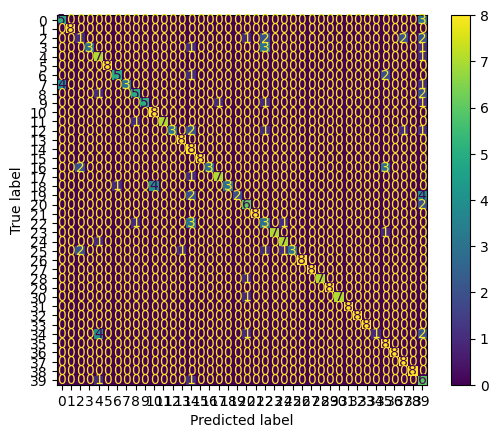

In [35]:
from sklearn.model_selection import GridSearchCV
# Test the model to choose the best C, degree, gamma, kernel
def run_svm_with_hyperparameter_tuning(x_train, y_train, x_val, y_val, x_test, y_test, scenario, GALLERY_SIZE):
    print(f'SVM model with hyperparameter tuning for scenario {scenario}')


    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto'],
        'degree': [2, 3, 4]
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(SVC(), param_grid, cv=GALLERY_SIZE, scoring='accuracy', verbose=1)

    # Fit the model on the training and validation data
    grid_search.fit(np.vstack((x_train, x_val)), np.hstack((y_train, y_val)))

    # Print out the best parameters
    print("Best parameters found: ", grid_search.best_params_)

    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    yfit = best_model.predict(x_test)
    print("\nClassification Report:\n", classification_report(y_test, yfit))
    conf_matrix = confusion_matrix(y_test, yfit)
    print("Confusion Matrix:\n", conf_matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.show()
run_svm_with_hyperparameter_tuning(x_train_1, y_train_1, x_val_1, y_val_1, x_test_1, y_test_1, 1, 2)

SVM model for scenario 1

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       1.00      1.00      1.00         8
           2       0.20      0.12      0.15         8
           3       1.00      0.38      0.55         8
           4       0.50      0.88      0.64         8
           5       1.00      1.00      1.00         8
           6       0.83      0.62      0.71         8
           7       1.00      0.38      0.55         8
           8       0.71      0.62      0.67         8
           9       1.00      0.62      0.77         8
          10       0.67      1.00      0.80         8
          11       1.00      0.88      0.93         8
          12       1.00      0.38      0.55         8
          13       0.89      1.00      0.94         8
          14       0.42      1.00      0.59         8
          15       1.00      1.00      1.00         8
          16       1.00      0.

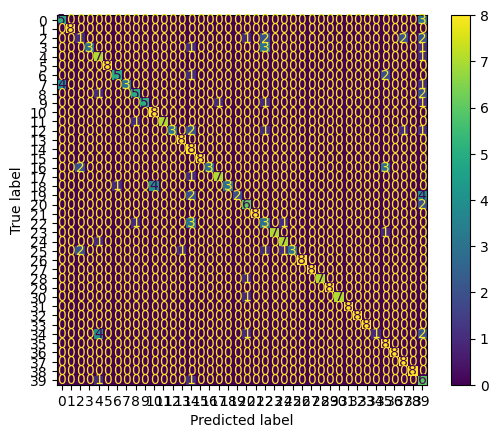

In [36]:
run_svm(x_train_1, x_test_1, y_train_1, y_test_1, 1)

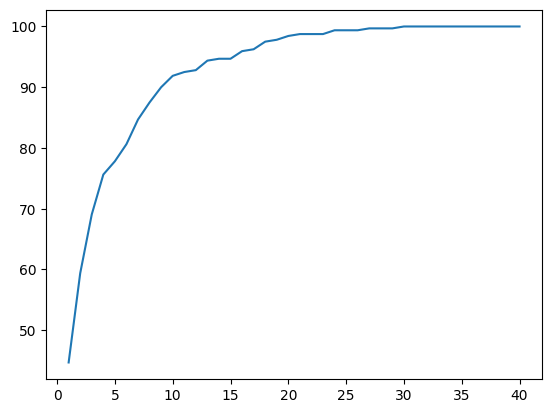

In [37]:
plot_CMC(x_train_1, y_train_1, x_test_1, y_test_1)

### Scenario 2


SVM model with hyperparameter tuning for scenario 2
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found:  {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       1.00      1.00      1.00         5
           2       1.00      0.40      0.57         5
           3       0.80      0.80      0.80         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00      1.00         5
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.60      0.60      0.60         5
          13      

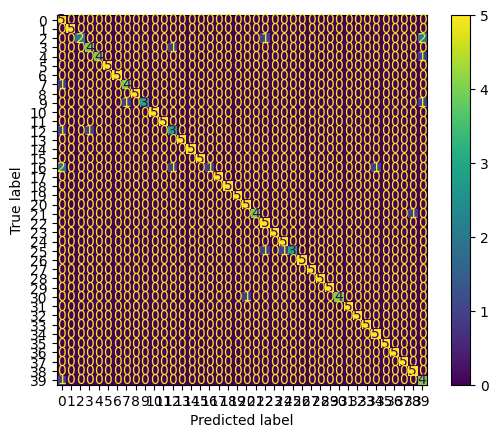

In [38]:
run_svm_with_hyperparameter_tuning(x_train_2, y_train_2, x_val_2, y_val_2, x_test_2, y_test_2, 2, 5)

SVM model for scenario 2

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       1.00      1.00      1.00         5
           2       1.00      0.40      0.57         5
           3       0.80      0.80      0.80         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00      1.00         5
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.60      0.60      0.60         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      0.

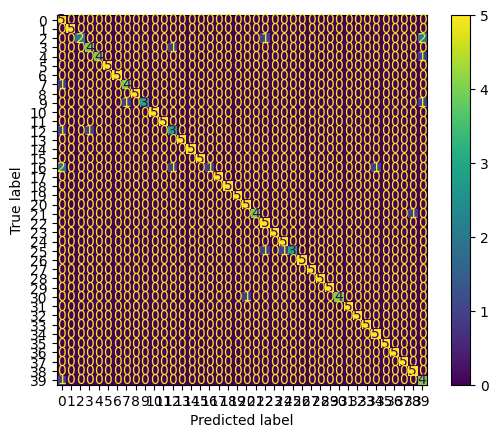

In [39]:
run_svm(x_train_2, x_test_2, y_train_2, y_test_2, 2)

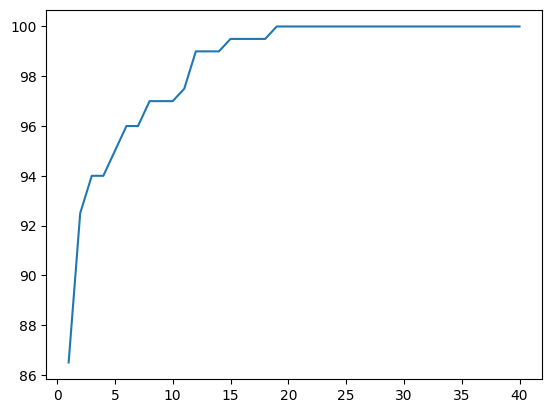

In [40]:
plot_CMC(x_train_2, y_train_2, x_test_2, y_test_2)

### Scenario 3


SVM model for scenario 3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.50      0.50      0.50         2
           8       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
  

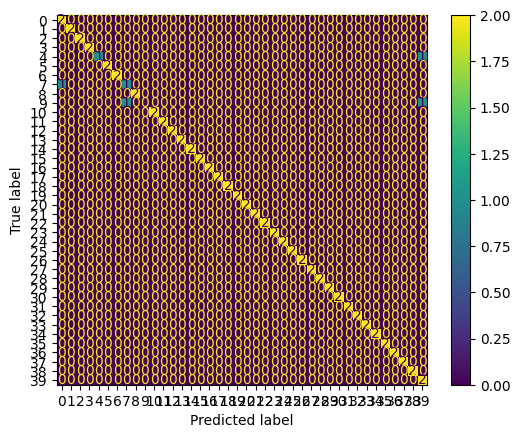

In [41]:
run_svm(x_train_3, x_test_3, y_train_3, y_test_3, 3)

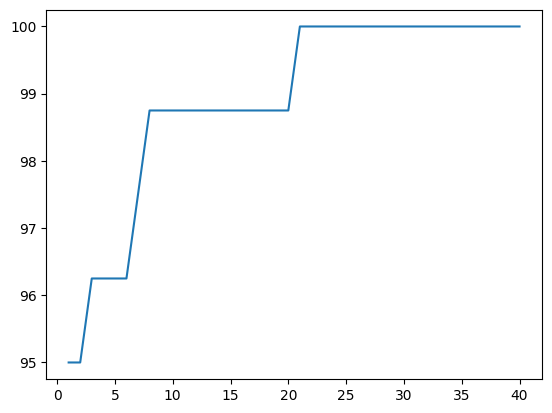

In [42]:
plot_CMC(x_train_3, y_train_3, x_test_3, y_test_3)

# Report my results


### Scenario 1


#### Accuracy

1. K -NN : 73%
2. PCA: 72% (50 eigenvectors)
3. LDA: 73%
4. SVM: 76%


### Scenario 2


#### Accuracy

1. K -NN : 88%
2. PCA: 88% (50 eigenvectors)
3. LDA: 90%
4. SVM: 90%


### Scenario 3


#### Accuracy

1. K -NN : 89%
2. PCA: 89% (50 eigenvectors)
3. LDA: 97%
4. SVM: 95%


# Conclusion


## Accuracy & Confusion matrix


On all scenarios and the overall accuracy, we can see that LDA, and SVM perform better on this task.

The accuracy is increased when we increase more training data as in scenario 2 and 3 where we use 5 images and 8 images for each class.

Looking at the confusion matrix for all models in all scenarios, there are no models that exhibit a strong bias towards a specific class (all scores are equal to 0 for that class), indicating that they perform well across all classes.


## CMC Curve


Among all models, the cmc curve of LDA performs best. We can see that at low rank, CMC curve of LDA reaches high (or maximum) recognition rates faster than any other models.

Therefore, from the result, we can choose LDA model as the final model for this task if we want to use a model.
